El análisis de datos de vuelos aéreos permite comprender mejor los patrones de movilidad, la eficiencia operativa de las aerolíneas y el comportamiento de la demanda de pasajeros. En este estudio se trabaja con un conjunto de datos de vuelos comerciales que incluye información sobre aerolíneas, rutas, horarios de salida y llegada, tipo de aeronave, número de pasajeros y características de los vuelos directos.

El objetivo principal es aplicar técnicas de limpieza, transformación y análisis exploratorio de datos (EDA), así como modelos de regresión lineal para identificar relaciones entre variables clave, como las horas de vuelo, el tipo de aeronave y la cantidad de pasajeros transportados.

El proceso se divide en varias etapas:

Carga y preparación de datos: detección y tratamiento de valores faltantes, estandarización de horarios y categorización de variables.

Análisis exploratorio (EDA): distribución de aeronaves, conteo de vuelos por ruta y aeropuerto, correlación entre variables y visualización gráfica.

Modelado estadístico: construcción de un modelo de regresión lineal para estimar la relación entre número de pasajeros y variables explicativas seleccionadas.

Evaluación de resultados: análisis de los residuales, comparación entre valores reales y predichos, e interpretación de los hallazgos.

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import statsmodels.api as sm
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd
from regex import T

carga de datos

In [316]:
df =pd.read_csv('Airline Flight Datasets.csv')
df.head()

,airline,flight_number,Origin,Destination,Scheduled_Departure_Time,Scheduled_Arrival_time,Aircraft_Type,No_of_Passengers,Direct_Flights
0,IndiGo,6E 123,Delhi,Mumbai,6:00,8:00,Airbus A320,175.0,Yes
1,Air India,AI 456,Mumbai,Delhi,7:00,9:00,Boeing 777,210.0,Yes
2,Vistara,UK 789,Bengaluru,Delhi,8:00,10:30,Airbus A321,232.0,Yes
3,SpiceJet,SG 234,Hyderabad,Mumbai,9:00,10:30,Boeing 737,162.0,Yes
4,IndiGo,6E 567,Kolkata,Mumbai,10:00,12:30,Airbus A320,175.0,Yes


Limpieza de datos

In [317]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   airline                   758 non-null    object 
 1   flight_number             759 non-null    object 
 2   Origin                    758 non-null    object 
 3   Destination               759 non-null    object 
 4   Scheduled_Departure_Time  760 non-null    object 
 5   Scheduled_Arrival_time    754 non-null    object 
 6   Aircraft_Type             760 non-null    object 
 7   No_of_Passengers          683 non-null    float64
 8   Direct_Flights            760 non-null    object 
dtypes: float64(1), object(8)
memory usage: 53.6+ KB


In [318]:
df["Scheduled_Departure_Time"] = df["Scheduled_Departure_Time"].apply(
    lambda x: parser.parse(x) if isinstance(x, str) else x
)

In [319]:
df["Scheduled_Departure_Time"] = df["Scheduled_Departure_Time"].apply(
    lambda t: t.replace(year=2025, month=9, day=11)
)

In [320]:
absolute_frequencies = df['Scheduled_Arrival_time'].value_counts()
print(absolute_frequencies)

Scheduled_Arrival_time
12:00            42
14:00            36
13:00            33
11:00            33
18:00            30
                 ..
10:00 PM (+1)     1
11:00 PM (+1)     1
1:45 PM           1
3:15 PM           1
2:30 PM           1
Name: count, Length: 114, dtype: int64


In [321]:
def parse_time(x):
    # Detectar días extra (+1, +2, etc.)
    days_ahead = 0
    if "(+" in x:
        days_ahead = int(x.split("(+")[1].replace(")", ""))
        x = x.split("(")[0].strip()
    
    # Parsear hora con dateutil (detecta 24h y AM/PM automáticamente)
    t = parser.parse(x)
    
    # Asignar fecha base fija y sumar días extra
    base = t.replace(year=2025, month=9, day=11)
    return base + pd.Timedelta(days=days_ahead)
df.dropna(subset=["Scheduled_Arrival_time"], inplace=True)
df["Scheduled_Arrival_time"] = df["Scheduled_Arrival_time"].apply(parse_time)


In [322]:
df["hour_in_air"] = ((df["Scheduled_Arrival_time"] -df["Scheduled_Departure_Time"])/ pd.Timedelta(hours =1))

In [323]:
df = df[(df["hour_in_air"] >= 0) & (df["hour_in_air"] <= 11)]


In [324]:
df = df[~df["Aircraft_Type"].astype(str).str.contains(r"\(", na=False)]



In [325]:
df['Aircraft_Type_cat'] = df['Aircraft_Type'].astype('category').cat.codes
df['Origin_cat'] = df['Origin'].astype('category').cat.codes
df["Destination_cat"] = df['Destination'].astype('category').cat.codes
df["Direct_Flights_cat"] = df['Direct_Flights'].astype('category').cat.codes



In [ ]:
df = df[df["No_of_Passengers"] <= 300]
df = df[df["Aircraft_Type_cat"] <= 21]

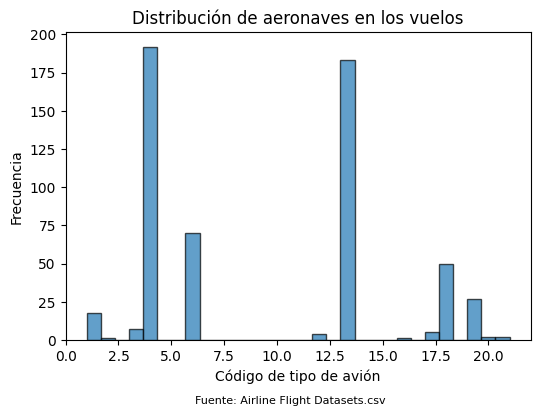

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["Aircraft_Type_cat"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Código de tipo de avión")
plt.ylabel("Frecuencia")
plt.title("Distribución de aeronaves en los vuelos")
plt.show()


In [ ]:

app = Dash(__name__)

app.layout = html.Div([
    html.H3("Flight Data Regression Analysis"),

    html.Label("Select X (predictor)"),
    dcc.Dropdown(
        id="x_dropdown",
        options=[{"label": col, "value": col} for col in df.select_dtypes(include=["number"]).columns],
        value="hour_in_air"
    ),

    html.Label("Select Y (dependent variable)"),
    dcc.Dropdown(
        id="y_dropdown",
        options=[{"label": col, "value": col} for col in df.select_dtypes(include=["number"]).columns],
        value="No_of_Passengers",
       
    ),

    dcc.Graph(id="regression_plot"),
])


@app.callback(
    Output("regression_plot", "figure"),
    [Input("x_dropdown", "value"),
     Input("y_dropdown", "value")]
)
def update_regression(x_col, y_col):
    fig = px.scatter(df, x=x_col, y=y_col, trendline="ols", color="Aircraft_Type")
    fig.update_layout(title=f"Regression: {y_col} ~ {x_col}",
                      xaxis_title=x_col,
                      yaxis_title=y_col)
    return fig


if __name__ == "__main__":
    app.run(debug=True)


c:\Users\frank\Documents\PY\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\frank\Documents\PY\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\frank\Documents\PY\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\frank\Documents\PY\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\frank\Documents\PY\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\frank\Documents\PY\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\frank\Documents\PY\.venv\Lib\site-pac

In [329]:
# Conteo de vuelos por aeropuerto de origen
origin_counts = df["Origin"].value_counts()

# Conteo de vuelos por aeropuerto de destino
destination_counts = df["Destination"].value_counts()

print("Top aeropuertos de origen:\n", origin_counts.head())
print("\nTop aeropuertos de destino:\n", destination_counts.head())


Top aeropuertos de origen:
 Origin
Delhi              12
Melbourne (MEL)     9
Mumbai              9
Bangkok (BKK)       8
Kolkata             8
Name: count, dtype: int64

Top aeropuertos de destino:
 Destination
Delhi          19
Mumbai         15
Cairo           9
Kolkata         8
Cairo (CAI)     8
Name: count, dtype: int64


In [330]:
# Crear columna de ruta
df["Route"] = df["Origin"] + " → " + df["Destination"]

# Contar las rutas más comunes
top_routes = df["Route"].value_counts().head(20)
print("Top 5 rutas más frecuentes:\n", top_routes)


Top 5 rutas más frecuentes:
 Route
Mumbai → Delhi                          3
Kolkata → Delhi                         3
Port of Spain (POS) → Kingston (KIN)    3
Kingston (KIN) → Port of Spain (POS)    3
San Juan (SJU) → Santo Domingo (SDQ)    3
Nassau (NAS) → Providenciales (PLS)     3
Antigua (ANU) → Sint Maarten (SXM)      3
Mumbai → Kochi                          2
Bengaluru → Guwahati                    2
Hyderabad → Vizag                       2
Varanasi → Delhi                        2
Guwahati → Delhi                        2
Columbia → Columbia                     2
Delhi → Kolkata                         2
Frankfurt → Vienna                      2
New York → Miami                        2
Brazil → Brazil                         2
Chennai → Mumbai                        2
Kochi → Mumbai                          2
Hyderabad → Chennai                     2
Name: count, dtype: int64


In [331]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz origen-destino
route_matrix = df.pivot_table(
    index="Origin", 
    columns="Destination", 
    values="Route", 
    aggfunc="count", 
    fill_value=0
)




In [332]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, 0 to 759
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   airline                   560 non-null    object        
 1   flight_number             561 non-null    object        
 2   Origin                    561 non-null    object        
 3   Destination               561 non-null    object        
 4   Scheduled_Departure_Time  562 non-null    datetime64[ns]
 5   Scheduled_Arrival_time    562 non-null    datetime64[ns]
 6   Aircraft_Type             562 non-null    object        
 7   No_of_Passengers          562 non-null    float64       
 8   Direct_Flights            562 non-null    object        
 9   hour_in_air               562 non-null    float64       
 10  Aircraft_Type_cat         562 non-null    int8          
 11  Origin_cat                562 non-null    int16         
 12  Destination_cat           5

Heatmap de correlación

                    No_of_Passengers  hour_in_air  Aircraft_Type_cat  \
No_of_Passengers            1.000000     0.463620           0.294901   
hour_in_air                 0.463620     1.000000           0.339058   
Aircraft_Type_cat           0.294901     0.339058           1.000000   
Origin_cat                 -0.022481    -0.012715          -0.045880   
Destination_cat            -0.062957     0.022080          -0.011434   
Direct_Flights_cat         -0.114287    -0.103064          -0.073197   

                    Origin_cat  Destination_cat  Direct_Flights_cat  
No_of_Passengers     -0.022481        -0.062957           -0.114287  
hour_in_air          -0.012715         0.022080           -0.103064  
Aircraft_Type_cat    -0.045880        -0.011434           -0.073197  
Origin_cat            1.000000        -0.000699            0.001691  
Destination_cat      -0.000699         1.000000           -0.067448  
Direct_Flights_cat    0.001691        -0.067448            1.000000  


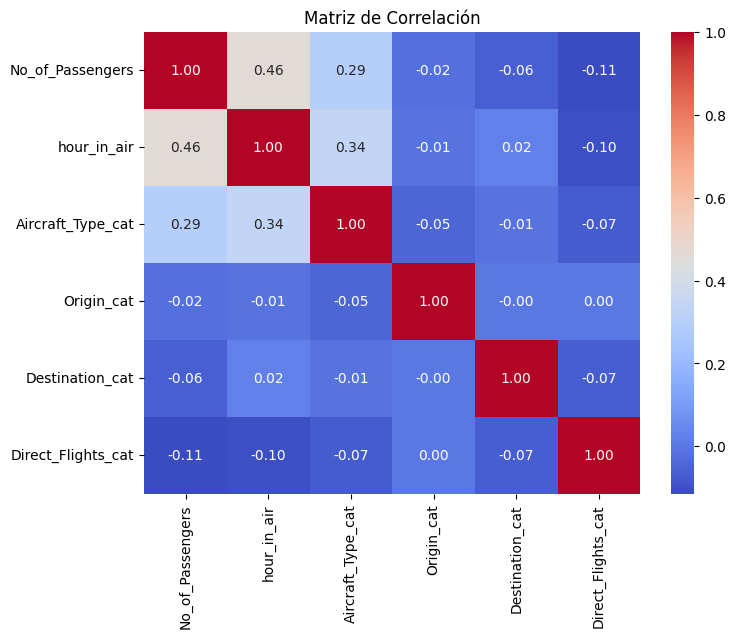

In [333]:
corr_matrix = df.corr(numeric_only=True)

# Mostrar matriz
print(corr_matrix)
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()


In [334]:
df_reg = df[['No_of_Passengers','hour_in_air','Aircraft_Type_cat']].dropna()
df_reg = pd.get_dummies(df_reg, drop_first=True)

X = df_reg.drop(columns=['No_of_Passengers'])
y = df_reg['No_of_Passengers']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       No_of_Passengers   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     86.51
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.84e-33
Time:                        17:26:36   Log-Likelihood:                -2834.8
No. Observations:                 562   AIC:                             5676.
Df Residuals:                     559   BIC:                             5689.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               147.3882      3.38

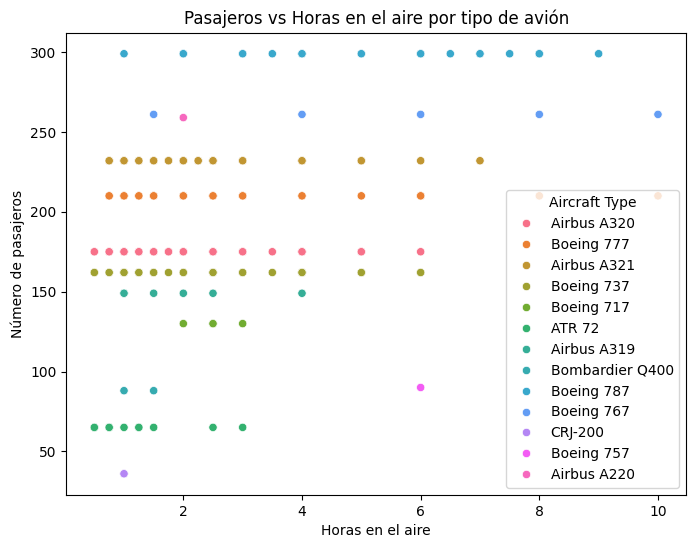

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x="hour_in_air", y="No_of_Passengers", hue="Aircraft_Type", data=df)
plt.title("Pasajeros vs Horas en el aire por tipo de avión")
plt.xlabel("Horas en el aire")
plt.ylabel("Número de pasajeros")
plt.legend(title="Aircraft Type")
plt.show()


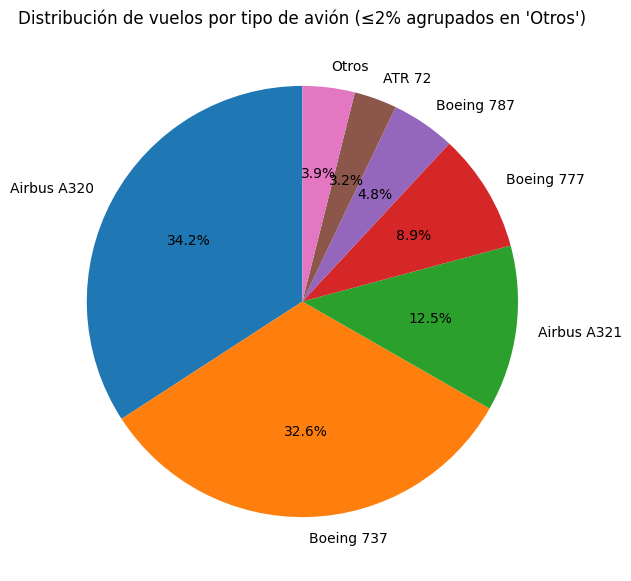

In [336]:

# Conteo por tipo de avión
aircraft_counts = df["Aircraft_Type"].value_counts()

# Calcular porcentaje
aircraft_percent = aircraft_counts / aircraft_counts.sum() * 100

# Separar principales y "otros"
main_aircraft = aircraft_counts[aircraft_percent > 2]
others = aircraft_counts[aircraft_percent <= 2].sum()

# Combinar en una sola serie
aircraft_final = main_aircraft.copy()
if others > 0:
    aircraft_final["Otros"] = others

# Graficar pie chart
plt.figure(figsize=(7,7))
plt.pie(aircraft_final, labels=aircraft_final.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribución de vuelos por tipo de avión (≤2% agrupados en 'Otros')")
plt.show()


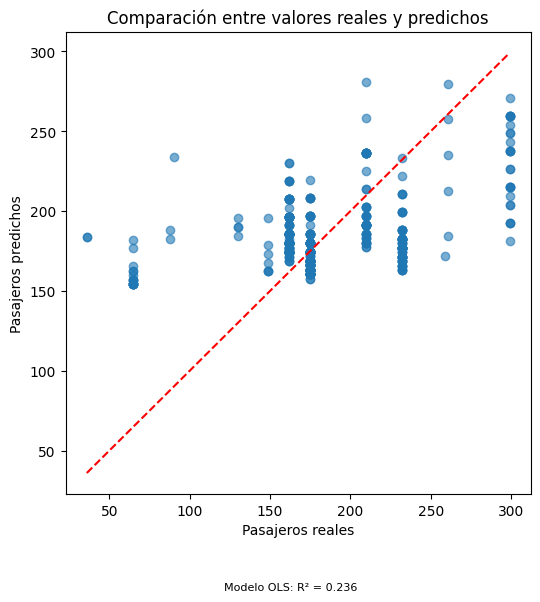

In [340]:
plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Pasajeros reales")
plt.ylabel("Pasajeros predichos")
plt.title("Comparación entre valores reales y predichos")
plt.figtext(0.5, -0.05, "Modelo OLS: R² = 0.236", ha="center", fontsize=8)
plt.show()


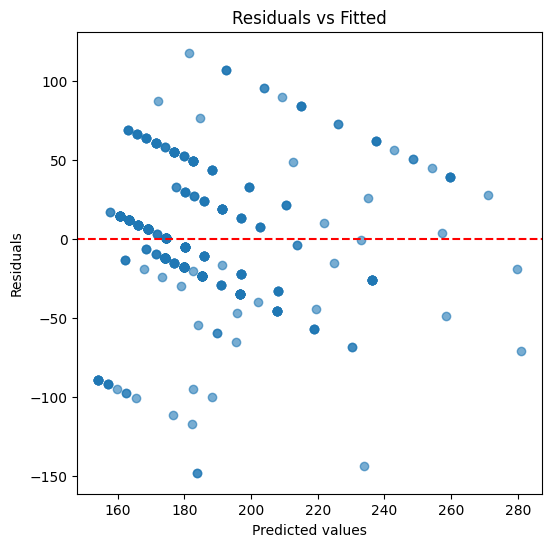

In [338]:
residuals = y - y_pred

plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


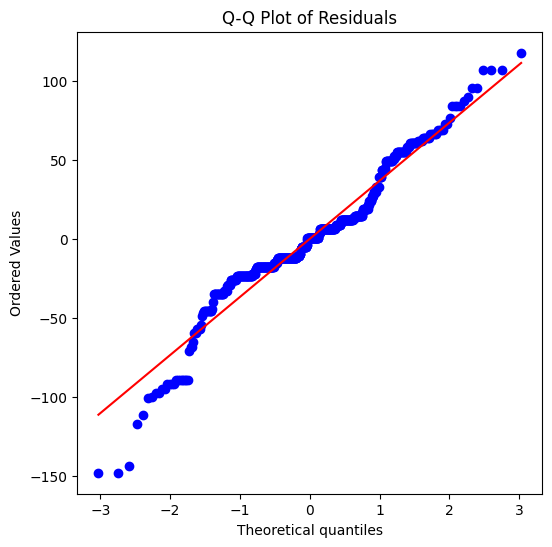

In [339]:
import scipy.stats as stats

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()
